## Set environment

In [1]:
# Import Google Drive libraries
!pip install pydicom
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pydicom
import matplotlib.pyplot as plt
import scipy.misc
import pandas as pd
import numpy as np
import cv2
from PIL import Image
from os import listdir
import os
from fastai.vision import *
import pandas
from google.colab.patches import cv2_imshow
from pathlib import Path

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 7.9 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Create a DataFrame



In [4]:
# Put the csv in the drive (in this path), so you don't have to download it every time
df = pd.read_csv('/content/drive/MyDrive/DP4/train.csv')

In [5]:
# The DataFrame contains 'SOPIntanceUID' (name of the dicom file but without the ending) and 'Target' (body part)
df

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10062189329714053601...,14
1,1.2.826.0.1.3680043.8.498.53411283183733547704...,3
2,1.2.826.0.1.3680043.8.498.12955484645689261949...,3
3,1.2.826.0.1.3680043.8.498.10408703585974384892...,3
4,1.2.826.0.1.3680043.8.498.30255106562321206269...,9
...,...,...
1273,1.2.826.0.1.3680043.8.498.61418411983294329010...,3
1274,1.2.826.0.1.3680043.8.498.10229701585590529671...,6
1275,1.2.826.0.1.3680043.8.498.67348831696239827753...,11
1276,1.2.826.0.1.3680043.8.498.10105498531842222086...,3


## Count graph by Target

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

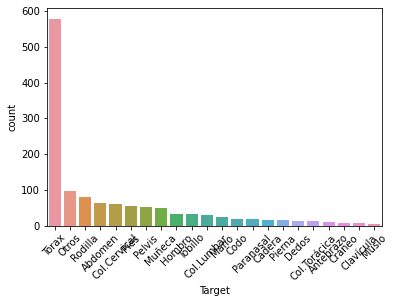

In [6]:
import seaborn as sns
from google.colab import files
g = sns.countplot(x='Target', data=df, order = df['Target'].value_counts().index)
g.set_xticklabels(['Tórax','Otros','Rodilla','Abdomen','Col.Cervical','Pies','Pelvis','Muñeca','Hombro','Tobillo','Col.Lumbar','Mano','Codo','Paranasal','Cadera','Pierna','Dedos','Col.Torácica','Antebrazo','Cráneo','Clavícula','Muslo'])
plt.xticks(rotation=45)
sns.set(rc = {'figure.figsize':(18,8)})
plt.savefig('countplot.svg')
files.download('countplot.svg')

## Get the size of each xray (already in jpg) and put it in a second DataFrame

In [8]:
from zipfile import ZipFile
with ZipFile('/content/drive/MyDrive/DP4/train_jpg.zip', 'r') as zipObj:

   # Extract all the contents of zip file in current directory

   zipObj.extractall()

In [9]:
images_folder = listdir('/content/content/train_png')
files = os.listdir('/content/content/train_png')

image_size=[]
image_jpgname=[]

for filename in files:
    print(filename)
    img=cv2.imread('/content/content/train_png/'+filename)
    image_size.append(img.shape)
    image_jpgname.append(filename)
    print(img.shape)

1.2.826.0.1.3680043.8.498.28879850432609288464497456935227556370.jpg
(3480, 4240, 3)
1.2.826.0.1.3680043.8.498.67498246555904727222770760880185608565.jpg
(2920, 2320, 3)
1.2.826.0.1.3680043.8.498.40796613291369558867442474084029345436.jpg
(2320, 1720, 3)
1.2.826.0.1.3680043.8.498.65367782739053484696600623678658844526.jpg
(4240, 3480, 3)
1.2.826.0.1.3680043.8.498.22644062609859232323281488761606263873.jpg
(2920, 2320, 3)
1.2.826.0.1.3680043.8.498.71899403786732730287540270988796884167.jpg
(2920, 2320, 3)
1.2.826.0.1.3680043.8.498.35824889106322299582492675249107976239.jpg
(3480, 4240, 3)
1.2.826.0.1.3680043.8.498.12930692248476176083952906814681878481.jpg
(3480, 4240, 3)
1.2.826.0.1.3680043.8.498.30665311865627600105937006561553968755.jpg
(3480, 4240, 3)
1.2.826.0.1.3680043.8.498.64015834357407646072057674614026580751.jpg
(2920, 2320, 3)
1.2.826.0.1.3680043.8.498.72851109615241080787718935217138640285.jpg
(4240, 3480, 3)
1.2.826.0.1.3680043.8.498.70205111740756550243801860180222841556.

In [10]:
df2 = pd.DataFrame(image_size,image_jpgname)
df2.columns = ['width','height','rgb']
df2['width_height'] = df2['width'].map(str) + 'x' + df2['height'].map(str) 
df2

,width,height,rgb,width_height
1.2.826.0.1.3680043.8.498.28879850432609288464497456935227556370.jpg,3480,4240,3,3480x4240
1.2.826.0.1.3680043.8.498.67498246555904727222770760880185608565.jpg,2920,2320,3,2920x2320
1.2.826.0.1.3680043.8.498.40796613291369558867442474084029345436.jpg,2320,1720,3,2320x1720
1.2.826.0.1.3680043.8.498.65367782739053484696600623678658844526.jpg,4240,3480,3,4240x3480
1.2.826.0.1.3680043.8.498.22644062609859232323281488761606263873.jpg,2920,2320,3,2920x2320
...,...,...,...,...
1.2.826.0.1.3680043.8.498.26289595829814765818003715764752723727.jpg,2320,1720,3,2320x1720
1.2.826.0.1.3680043.8.498.60719045727510389225890019822889328195.jpg,2320,2920,3,2320x2920
1.2.826.0.1.3680043.8.498.40993113465022153717657413259256413865.jpg,4240,3480,3,4240x3480
1.2.826.0.1.3680043.8.498.41087132862065136486236752254052399923.jpg,2920,2320,3,2920x2320


In [11]:
df2['SOPInstanceUID'] = df2.index[0][:-4]

## image_size graphs

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

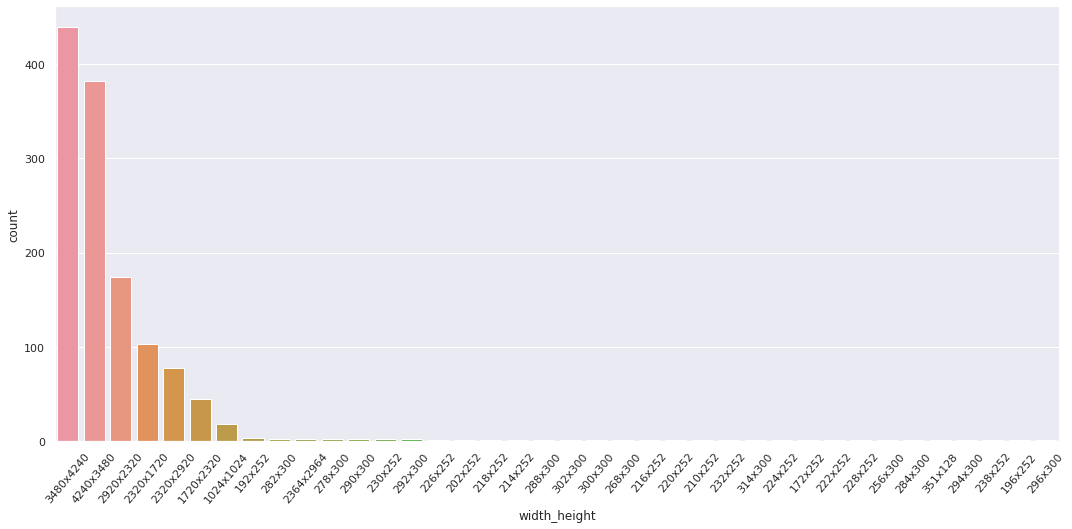

In [12]:
import seaborn as sns
from google.colab import files
sns.countplot(x='width_height', data=df2, order = df2['width_height'].value_counts().index)
plt.xticks(rotation=50)
plt.savefig('countplot2.svg')
files.download('countplot2.svg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

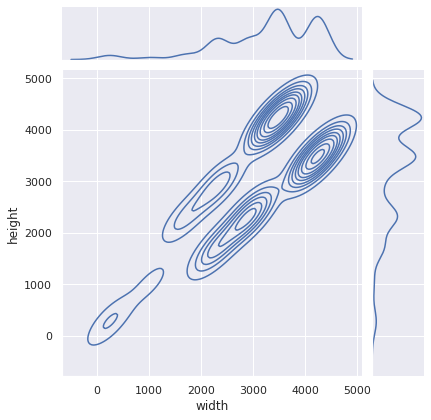

In [13]:
sns.jointplot(x='width',y='height',data=df2, kind='kde')
sns.set(rc = {'figure.figsize':(39,14)})
plt.xticks(rotation=45)
plt.savefig('jointplot.svg')
files.download('jointplot.svg')

## Top 5 values on image_size, width and height

In [14]:
df2['width_height'].value_counts().head(5)

3480x4240    439
4240x3480    382
2920x2320    174
2320x1720    103
2320x2920     78
Name: width_height, dtype: int64

In [15]:
df2['width'].value_counts().head(5)

3480    439
4240    382
2320    181
2920    174
1720     45
Name: width, dtype: int64

In [16]:
df2['height'].value_counts().head(5)

4240    439
3480    382
2320    219
1720    103
2920     78
Name: height, dtype: int64